In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

import warnings
warnings.filterwarnings('ignore')

In [3]:
tf.keras.utils.set_random_seed(1917) #For reproducibility

The code block below defines a few helper functions to visualize the results. You do not need to touch them.

In [4]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue).

In [5]:
# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


(<Figure size 1000x1000 with 100 Axes>, <Axes: >)

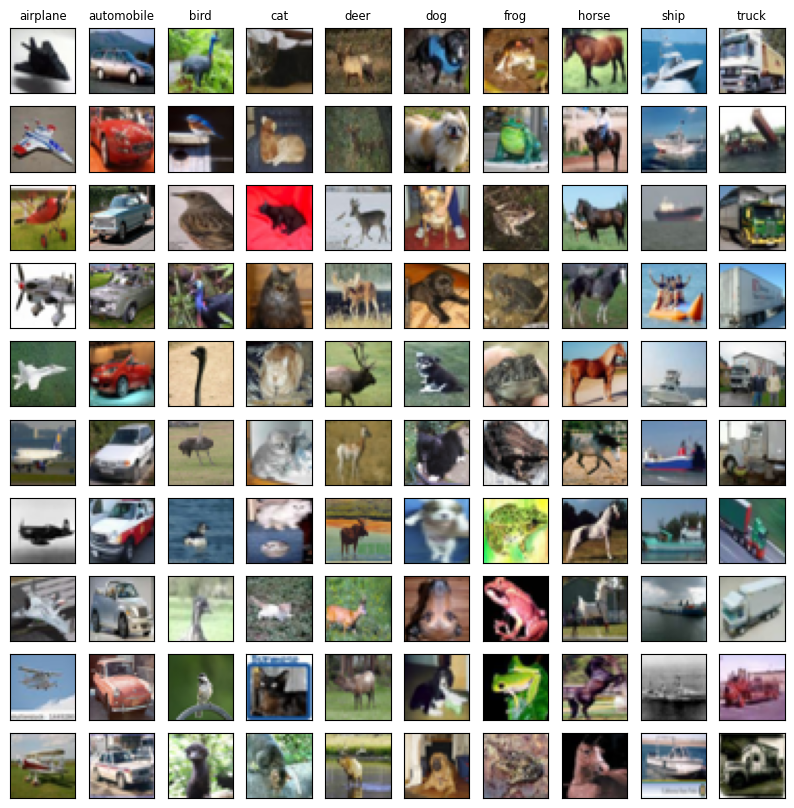

In [6]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(x_train, y_train)

In [7]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
# Normalize
x_train_norm = x_train / 255
x_test_norm = x_test / 255

# Hint: use 20% of the training data for validation
x_valid_norm = x_test_norm[8000:]
x_test_norm = x_test_norm[:8000]

print("x_train shape:", x_train_norm.shape)
print(x_train_norm.shape[0], "train samples")
print(x_valid_norm.shape[0], "validation samples")
print(x_test_norm.shape[0], "test samples")
print("\ny_train shape:", y_train.shape)
print(y_train_onehot.shape[0], "train samples")
print(y_valid_onehot.shape[0], "validation samples")
print(y_test_onehot.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
2000 validation samples
8000 test samples

y_train shape: (50000, 1)
50000 train samples
2000 validation samples
8000 test samples


In [8]:
# reshape the image matrices to vectors
x_train_norm = x_train_norm.reshape(-1, 32**2*3)
x_valid_norm = x_valid_norm.reshape(-1, 32**2*3)
x_test_norm = x_test_norm.reshape(-1, 32**2*3)
print("x_train shape:", x_train_norm.shape)

x_train shape: (50000, 3072)


We start with a fully connected network

In [ ]:
# We try to select the best for it...
N = 20 # number of trials
search = {
    'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
    'learn_rate': np.random.choice([-5,-4, -3, -2, -1],N),
    'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
    'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
    'val_acc': np.zeros(N)
}

for i in range(N):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(256, activation = search['activation'][i], input_shape=(3072,)),
                      tf.keras.layers.Dense(256, activation = search['activation'][i], input_shape=(3072,)),
                      tf.keras.layers.Dropout(search['dropout'][i]),
                      tf.keras.layers.Dense(10, activation='softmax')])
  model.compile(loss='categorical_crossentropy',
  # optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1*10**int(search['learn_rate'][i])), metrics=['accuracy'])
  optimizer = tf.keras.optimizers.Adam(learning_rate=1*10**int(search['learn_rate'][i])), metrics=['accuracy'])
  results = model.fit(
        x_train_norm, y_train_onehot,
        validation_data=(x_valid_norm, y_valid_onehot),
        batch_size=search['batch_size'][i],
        epochs=10,
        verbose=0
      )
  search['val_acc'][i] = model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=128)[1]
  print(f"iteration {i}:")
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")

After some playing, trying to improve as much as possible the NN, we arrive to the following setup:

In [ ]:
nb_nodes = 256
activation = "relu"
output = 10
drop_rate = 0.25 # Between 0.2 and 0.5

model = tf.keras.models.Sequential([
    layers.Dense(nb_nodes, activation=activation, input_shape=(3072,)),
    layers.Dense(nb_nodes, activation=activation, input_shape=(3072,)),
    layers.Dropout(drop_rate), 
    layers.Dense(output), # output
    # softmax activation to transform output into probabilities
    layers.Activation('softmax')])
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    # the recommended loss
    loss='categorical_crossentropy',
    #optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # For M1/M2 macs works better
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # keras 3
    metrics=['accuracy']
)

model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=128,
    epochs=20,
    verbose=0,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

In [11]:
print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    [
        "Train",
        *model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Validation",
        *model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Test",
        *model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=nb_nodes)[1]) * 100,
    ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |    Loss |   Accuracy |   Test error rate [%] |
|------------+---------+------------+-----------------------|
| Train      | 1.31876 |   0.52904  |               47.096  |
| Validation | 1.4506  |   0.4875   |               51.25   |
| Test       | 1.43161 |   0.490875 |               50.9125 |


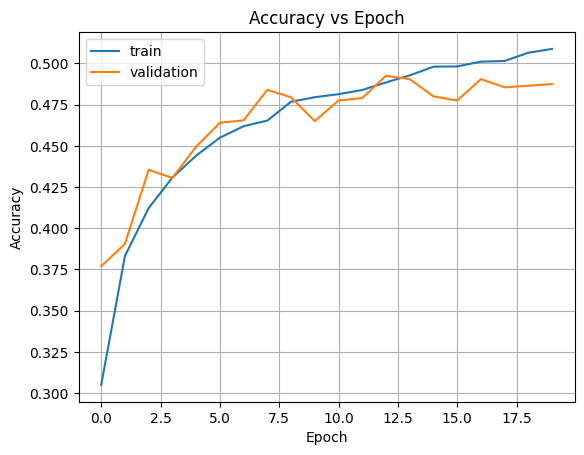

In [12]:
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots()
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch")
ax.grid(True)
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

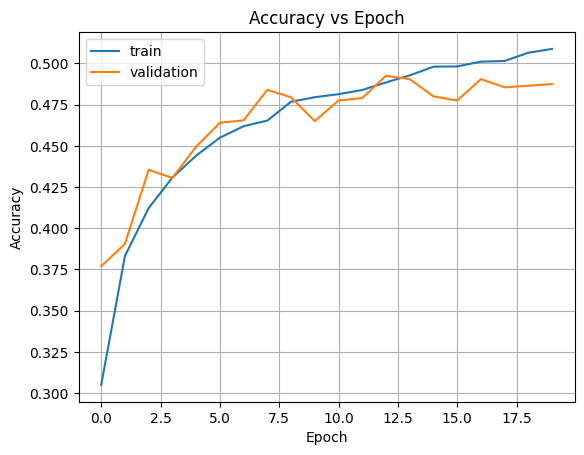

In [13]:
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots()
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch")
ax.grid(True)
ax.legend(['train', 'validation'], loc='upper left')

plt.show()

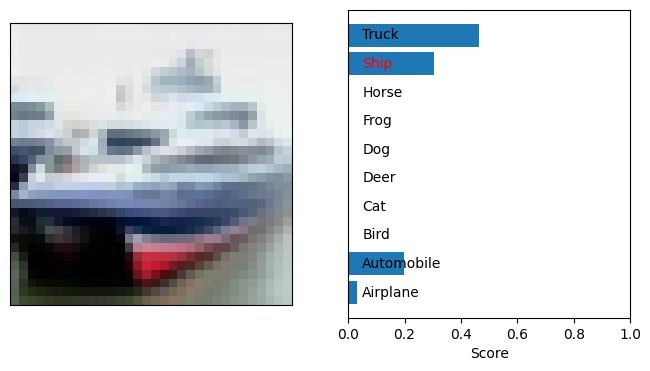

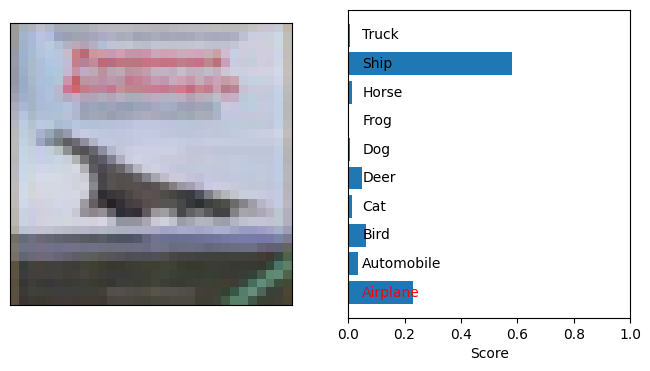

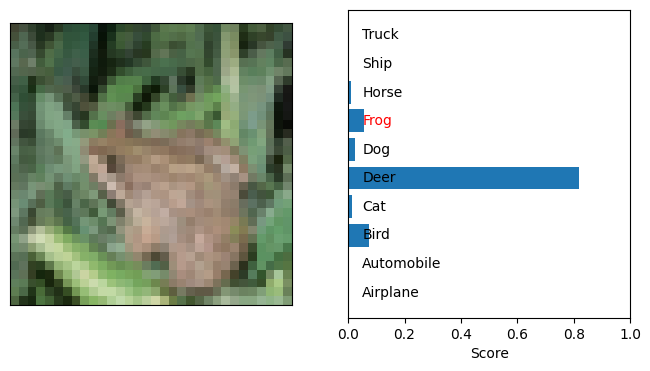

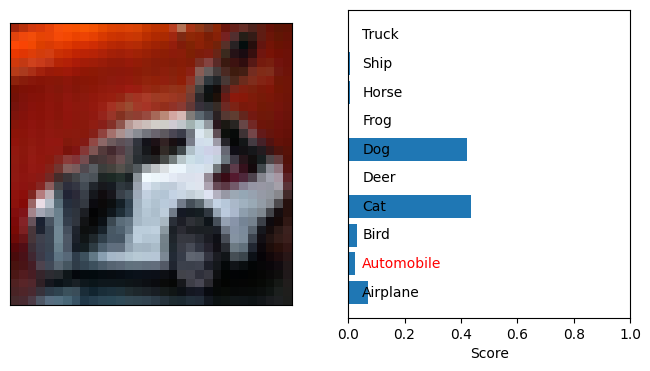

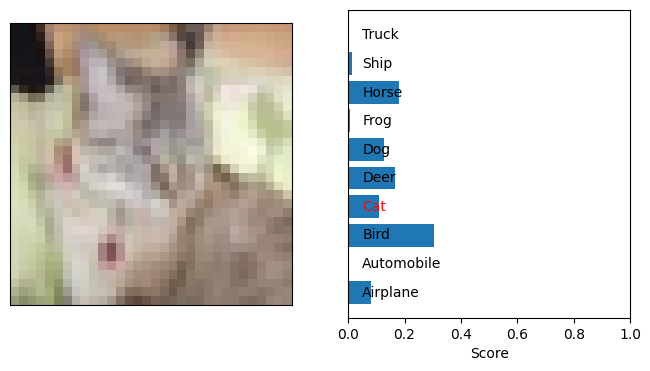

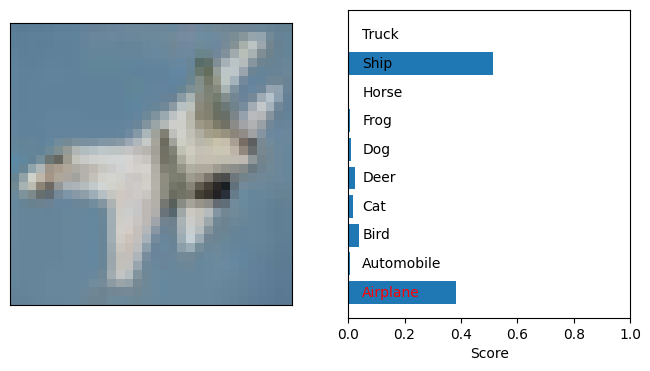

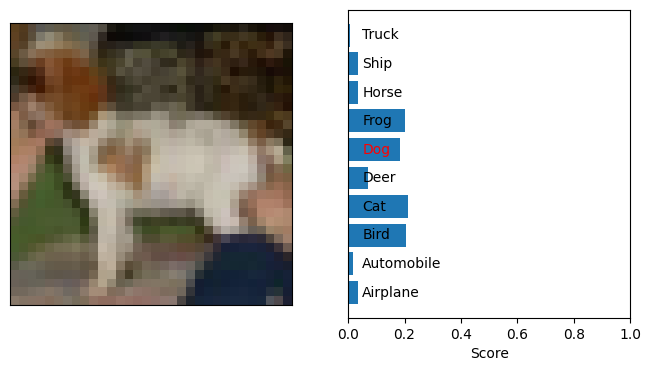

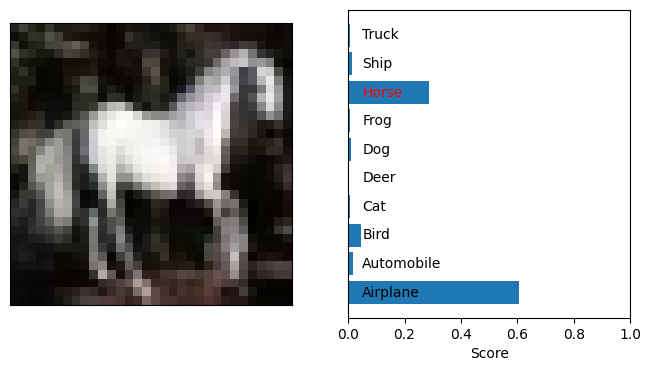

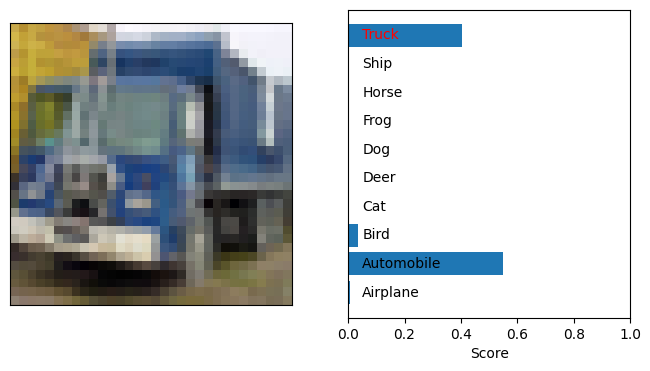

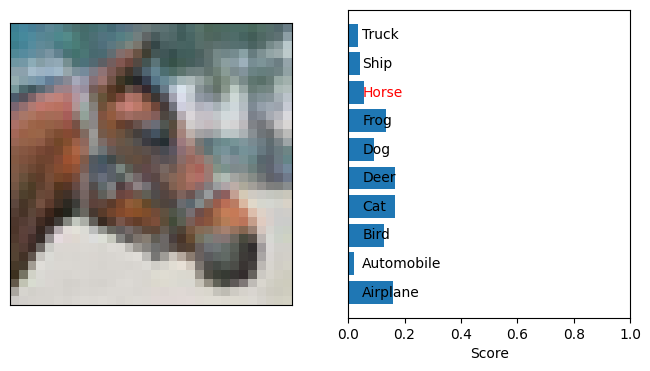

In [14]:
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128, verbose=0)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

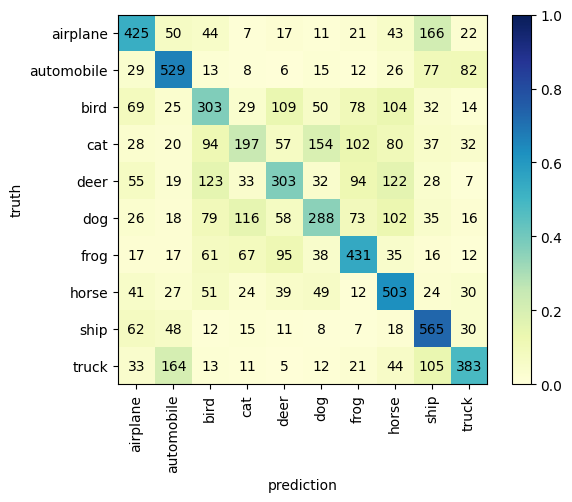

In [15]:
# Hint: this is how you can plot the confusion matrix.

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

**CNN**
In the second part of this exercise, classify the images with a CNN.


In [16]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ],
    name="cnn",
)

print(model.summary())

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,578 (99.91 KB)

 Trainable params: 25,578 (99.91 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss='categorical_crossentropy',
    #optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # For M1/M2 macs works better
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # keras 3
    metrics=['accuracy']
)

# Reshape before training
x_train_norm = x_train_norm.reshape(-1, 32, 32, 3)
x_valid_norm = x_valid_norm.reshape(-1, 32, 32, 3)
x_test_norm  = x_test_norm.reshape(-1, 32, 32, 3)

model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=128,
    epochs=40,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_cnn.csv".format(model.name))],
    verbose = 0
)

In [18]:
print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

x_test_norm  = x_test_norm.reshape(-1, 32, 32, 3)

table = [
    [
        "Train",
        *model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Validation",
        *model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Test",
        *model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=nb_nodes)[1]) * 100,
    ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |     Loss |   Accuracy |   Test error rate [%] |
|------------+----------+------------+-----------------------|
| Train      | 0.68845  |   0.76766  |               23.234  |
| Validation | 0.846012 |   0.7115   |               28.85   |
| Test       | 0.844429 |   0.718125 |               28.1875 |


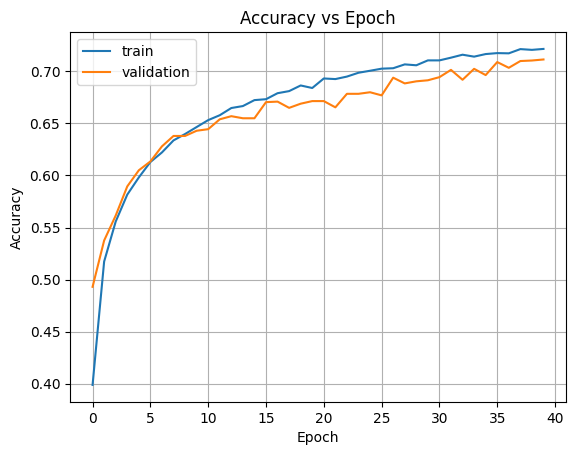

In [19]:
# training curves
history = np.genfromtxt("history_cnn.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots()
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch")
ax.grid(True)
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

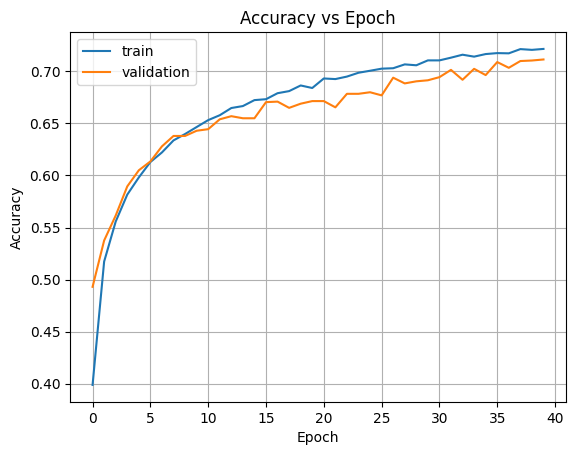

In [20]:
# training curves
history = np.genfromtxt("history_cnn.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots()
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch")
ax.grid(True)
ax.legend(['train', 'validation'], loc='upper left')

plt.show()

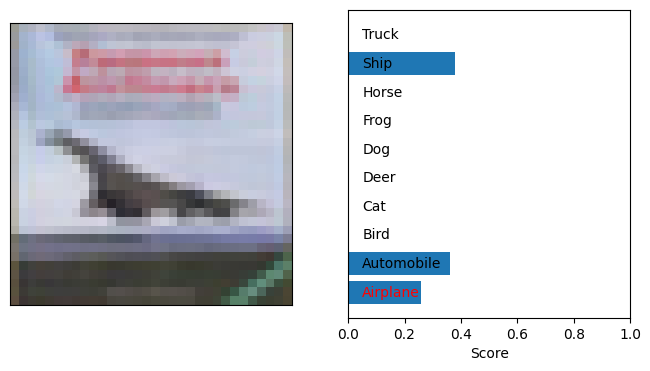

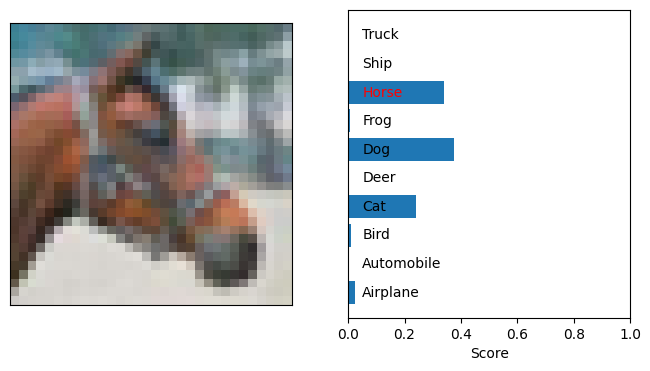

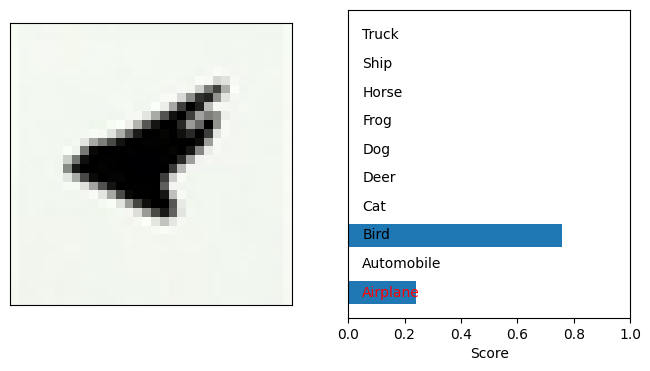

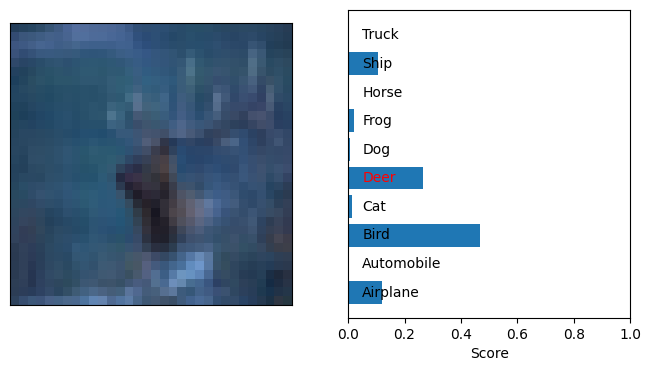

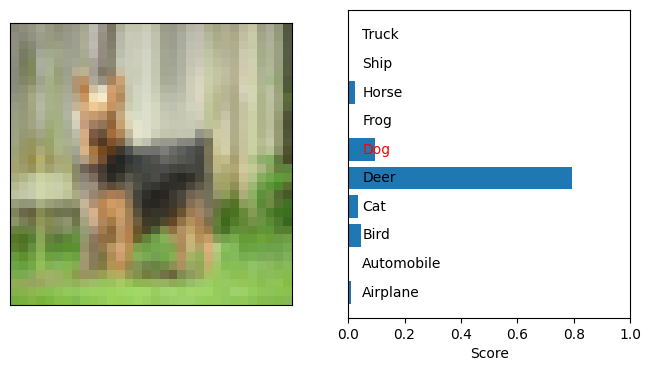

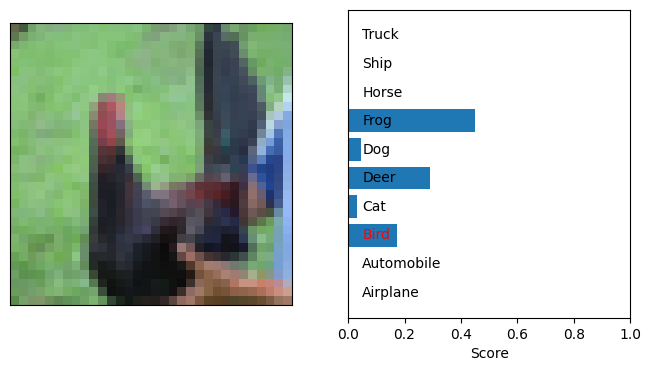

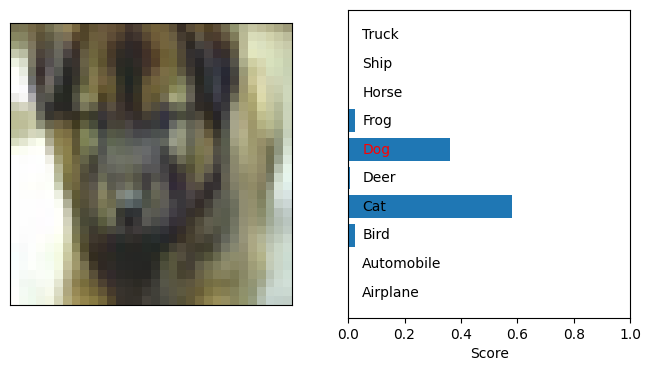

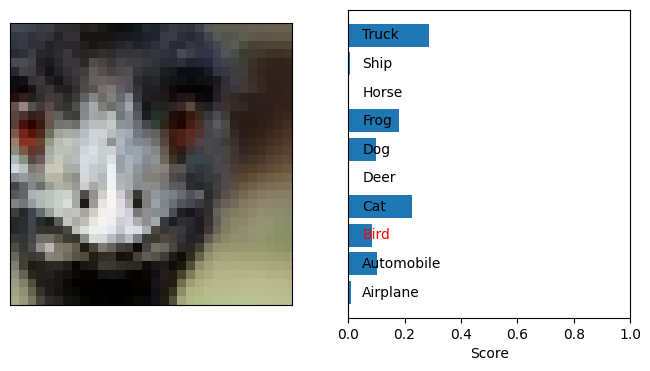

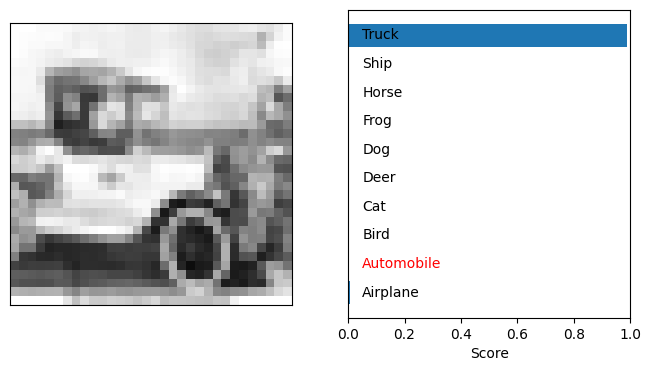

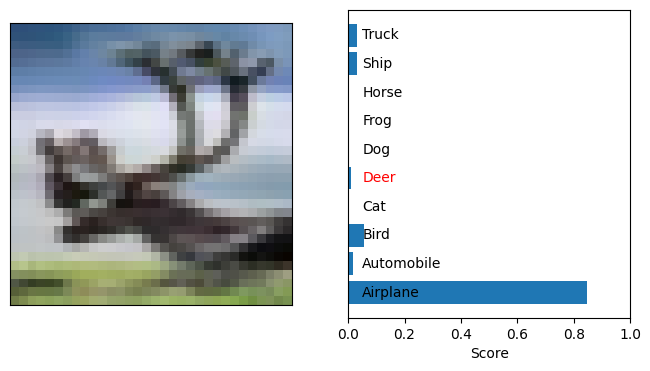

In [21]:
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128, verbose=0)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

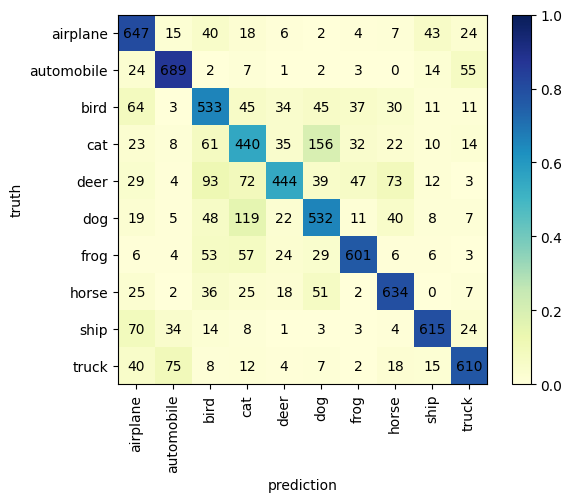

In [22]:
# Hint: this is how you can plot the confusion matrix.

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

# Final observations

* The fully-connected network achieves reasonable performance, but it is
clearly outperformed by the convolutional neural network. This is expected:
the dense model treats the input as a long 1D vector and therefore cannot
exploit the spatial structure of the images.

* In contrast, the CNN uses convolutional filters that learn local patterns
such as edges, textures, and shapes. Because of this, the CNN achieves higher
training, validation, and test accuracy, and it generalizes better. The
confusion matrix also shows fewer misclassifications, especially for visually
similar classes. Overall, the convolutional approach is more suitable for
image data and provides significantly better performance.
